In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import urllib.request
import time
from scipy.stats import linregress
from matplotlib.pyplot import axvline


In [2]:
#import datafile from CSV sample file and name as a variable (Should be the CSV file we downloaded from CA open data that Adam cleaned up)
NO3_data_import = "../CA_Water_Analysis/NO3_Water_Lab_Data.csv"
NO3_data = pd.read_csv(NO3_data_import)
NO3_data.head(2)

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
0,8166,01S04W04A001M,01S04W04A001M,01S04W04A001M,Groundwater,37.8788,122.3027,Review Status Unknown,Alameda,WDIS_0744258,08/29/1977 08:30,NaN,Feet,Dissolved Nitrate,5.6,0.1,mg/L,EPA 352.1 (DWR Modified)
1,8445,01S04W34F002M,01S04W34F002M,01S04W34F002M,Groundwater,37.8037,122.2938,Review Status Unknown,Alameda,WDIS_0744281,08/14/1973 11:00,NaN,Feet,Dissolved Nitrate,12.0,0.1,mg/L,EPA 352.1 (DWR Modified)


# Clean Up Data

In [3]:
#Clean data by splitting combined date and time from sample_date field into a single date only field.
for idx, row in NO3_data.iterrows(): 
    year=row['sample_date'].split(' ')[0].split('/')[-1]
    date=row['sample_date'].split(' ')[0]
    time=row['sample_date'].split(' ')[-1]
    new_date=date.split('/')[:-1]
    new_date=new_date+[f'{year}']
    new_date_str='/'.join(new_date)
    
    NO3_data.loc[idx, 'sample_date']=new_date_str

# Format Time Data

In [4]:
#convert sample date field to panda date format, print to check
NO3_data['sample_date'] = pd.to_datetime(NO3_data['sample_date'])

# Create DataFrame for 2012 to 2022
NO3_data_df = pd.DataFrame(NO3_data)
start_date = '2012-01-01'
end_date = '2022-12-31'
mask = (NO3_data_df['sample_date'] > start_date) & (NO3_data_df['sample_date'] <= end_date)
  
NO3_data_df = NO3_data_df.loc[mask]

#Display
NO3_data_df

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
403,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,D0122B0070,2022-01-18,1.00,Meters,Dissolved Nitrate,2.110,0.10,mg/L,EPA 300.0
404,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,D0122B0070,2022-01-18,1.00,Meters,Dissolved Nitrate + Nitrite,0.496,0.05,mg/L as N,Std Method 4500-NO3-F
405,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,D0116B0008,2016-01-19,1.00,Meters,Dissolved Nitrate,0.700,0.10,mg/L,EPA 300.0 28d Hold
406,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,D0116B0008,2016-01-19,1.00,Meters,Dissolved Nitrate + Nitrite,0.150,0.01,mg/L as N,Std Method 4500-NO3-F (DWR Modified)
407,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,DA0212B3393,2012-02-13,1.00,Meters,Dissolved Nitrate,0.000,0.10,mg/L,EPA 300.0 28d Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216362,45866,Yuba R@MO,Yuba R A MO,A6101050,Surface Water,39.1284,121.5976,Review Status Unknown,Yuba,N1115B0726,2015-11-10,0.15,Meters,Dissolved Nitrate + Nitrite,0.010,0.01,mg/L as N,Std Method 4500-NO3-F (DWR Modified)
216363,45866,Yuba R@MO,Yuba R A MO,A6101050,Surface Water,39.1284,121.5976,Review Status Unknown,Yuba,N1114B0773,2014-11-13,0.15,Meters,Dissolved Nitrate + Nitrite,0.020,0.01,mg/L as N,Std Method 4500-NO3-F (DWR Modified)
216364,45866,Yuba R@MO,Yuba R A MO,A6101050,Surface Water,39.1284,121.5976,Review Status Unknown,Yuba,N1116B0906,2016-11-14,0.15,Meters,Dissolved Nitrate + Nitrite,0.000,0.01,mg/L as N,Std Method 4500-NO3-F (DWR Modified)
216365,45866,Yuba R@MO,Yuba R A MO,A6101050,Surface Water,39.1284,121.5976,Review Status Unknown,Yuba,N1121B0442,2021-11-17,0.15,Meters,Dissolved Nitrate + Nitrite,0.000,0.05,mg/L as N,Std Method 4500-NO3-F


In [5]:
#count the number of samples for the period
Total_Dissolved_Nitrate_Samples = NO3_data_df.size

print(f"There were a total of {Total_Dissolved_Nitrate_Samples} Water Samples taken for Dissolved Nitrate between 2012 and 2022")

There were a total of 326484 Water Samples taken for Dissolved Nitrate between 2012 and 2022


# Sort Counties with Highest Levels of Dissolved Nitrate


In [6]:
#sort by the total amount of arsenic found (need to double check that all these values have been converted)
sorted_recent_df = NO3_data_df.sort_values(['result'], ascending=False)

#create a new dataframe from 500 top offenders--this can be a variable
top_offender_df = sorted_recent_df.head(1500)


#Find out who they are
total_dirty_counties = top_offender_df['county_name'].unique()
print(total_dirty_counties)

['Kern' 'Fresno' 'Kings' 'Merced' 'Lassen' 'Butte' 'San Joaquin' 'Tehama'
 'Colusa' 'Amador' 'Glenn' 'El Dorado' 'Sacramento' 'Napa' 'Calaveras'
 'Yolo' 'Yuba' 'Sierra' 'Modoc' 'Shasta' 'Solano' 'Los Angeles'
 'Contra Costa' 'Alameda' 'San Bernardino' 'Lake' 'Mendocino']


In [7]:
top_offender_df[top_offender_df['county_name']=="Lake"]["station_name"].value_counts()


CLEAR LK 23 OAKS ARM    1
CLEAR LK LO ARM CL3     1
Name: station_name, dtype: int64

In [8]:
top_offender_df['county_name'].value_counts().index

Index(['San Joaquin', 'Merced', 'Kern', 'Alameda', 'Sacramento',
       'Contra Costa', 'Tehama', 'Solano', 'Butte', 'Kings', 'Lassen', 'Glenn',
       'Los Angeles', 'Yolo', 'San Bernardino', 'Fresno', 'Napa', 'Calaveras',
       'Amador', 'Shasta', 'El Dorado', 'Colusa', 'Sierra', 'Modoc', 'Lake',
       'Yuba', 'Mendocino'],
      dtype='object')

In [9]:
top_offender_df.groupby(["county_name"])["station_name"].count()


county_name
Alameda           102
Amador              8
Butte              38
Calaveras           8
Colusa              3
Contra Costa       69
El Dorado           3
Fresno             20
Glenn              29
Kern              174
Kings              35
Lake                2
Lassen             35
Los Angeles        29
Mendocino           1
Merced            180
Modoc               2
Napa                8
Sacramento         97
San Bernardino     22
San Joaquin       482
Shasta              3
Sierra              2
Solano             58
Tehama             60
Yolo               29
Yuba                1
Name: station_name, dtype: int64

In [10]:
top_offender_df['county_name'].value_counts().index

Index(['San Joaquin', 'Merced', 'Kern', 'Alameda', 'Sacramento',
       'Contra Costa', 'Tehama', 'Solano', 'Butte', 'Kings', 'Lassen', 'Glenn',
       'Los Angeles', 'Yolo', 'San Bernardino', 'Fresno', 'Napa', 'Calaveras',
       'Amador', 'Shasta', 'El Dorado', 'Colusa', 'Sierra', 'Modoc', 'Lake',
       'Yuba', 'Mendocino'],
      dtype='object')

In [37]:
#Narrow down the top five
top_five_df = county_station_df.sort_values("result", ascending=False)
top_five_df.head()

,county,result
0,San Joaquin,128
2,Kern,85
4,Sacramento,76
1,Merced,61
6,Tehama,57


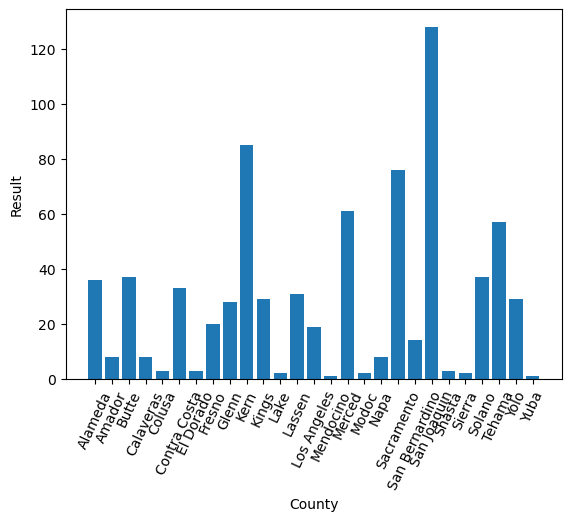

In [38]:
county_list = top_offender_df['county_name'].value_counts().index

c_list = []

for county in county_list:
    #print(county)
    df = top_offender_df.loc[top_offender_df['county_name']==county]
    #print(len(df))
    result = df["result"].nunique()
    #print(station_number)
    #df2 = df.loc[df.duplicated(subset=["station_name"])]["station_name"].nunique()
    #print(df2)
    
    county_dict = {}
    
    county_dict["county"] = county
    county_dict["result"] = result
    
    c_list.append(county_dict)
    
c_list    
    
county_station_df = pd.DataFrame(c_list)
county_station_df = county_station_df.sort_values("county")

plt.bar(county_station_df["county"], county_station_df["result"])
plt.xlabel("County")
plt.xticks(rotation=65)
plt.ylabel("Result")
#plt.axhline(x=2.5, color='red', linestyle='--', ymin=0, ymax=1)

plt.show()

# Chart for cities with highest levels in red


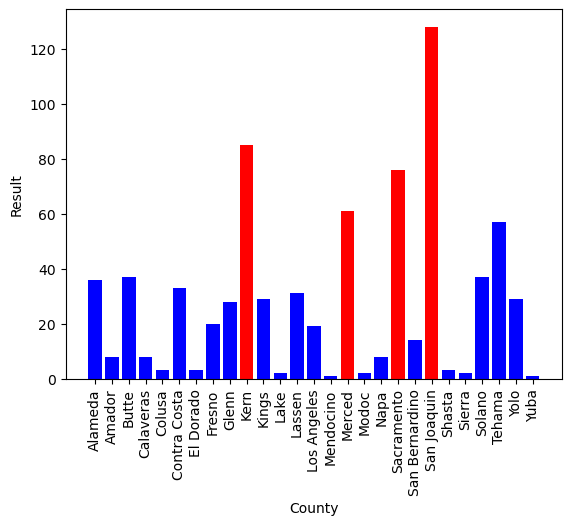

In [39]:
county_list = top_offender_df['county_name'].value_counts().index

c_list = []

for county in county_list:
    #print(county)
    df = top_offender_df.loc[top_offender_df['county_name']==county]
    #print(len(df))
    result = df["result"].nunique()
    #print(station_number)
    #df2 = df.loc[df.duplicated(subset=["station_name"])]["station_name"].nunique()
    #print(df2)
    
    county_dict = {}
    
    county_dict["county"] = county
    county_dict["result"] = result
    
    c_list.append(county_dict)
    
c_list    
    
county_station_df = pd.DataFrame(c_list)
county_station_df = county_station_df.sort_values("county")

plt.bar(county_station_df["county"], county_station_df["result"])
plt.xlabel("County")
plt.xticks(rotation=90)
plt.ylabel("Result")

top_4 = county_station_df.nlargest(4, "result")
for index, row in county_station_df.iterrows():
    if row["county"] in top_4["county"].values:
        plt.bar(row["county"], row["result"], color='red')
    else:
        plt.bar(row["county"], row["result"], color='blue')

plt.show()

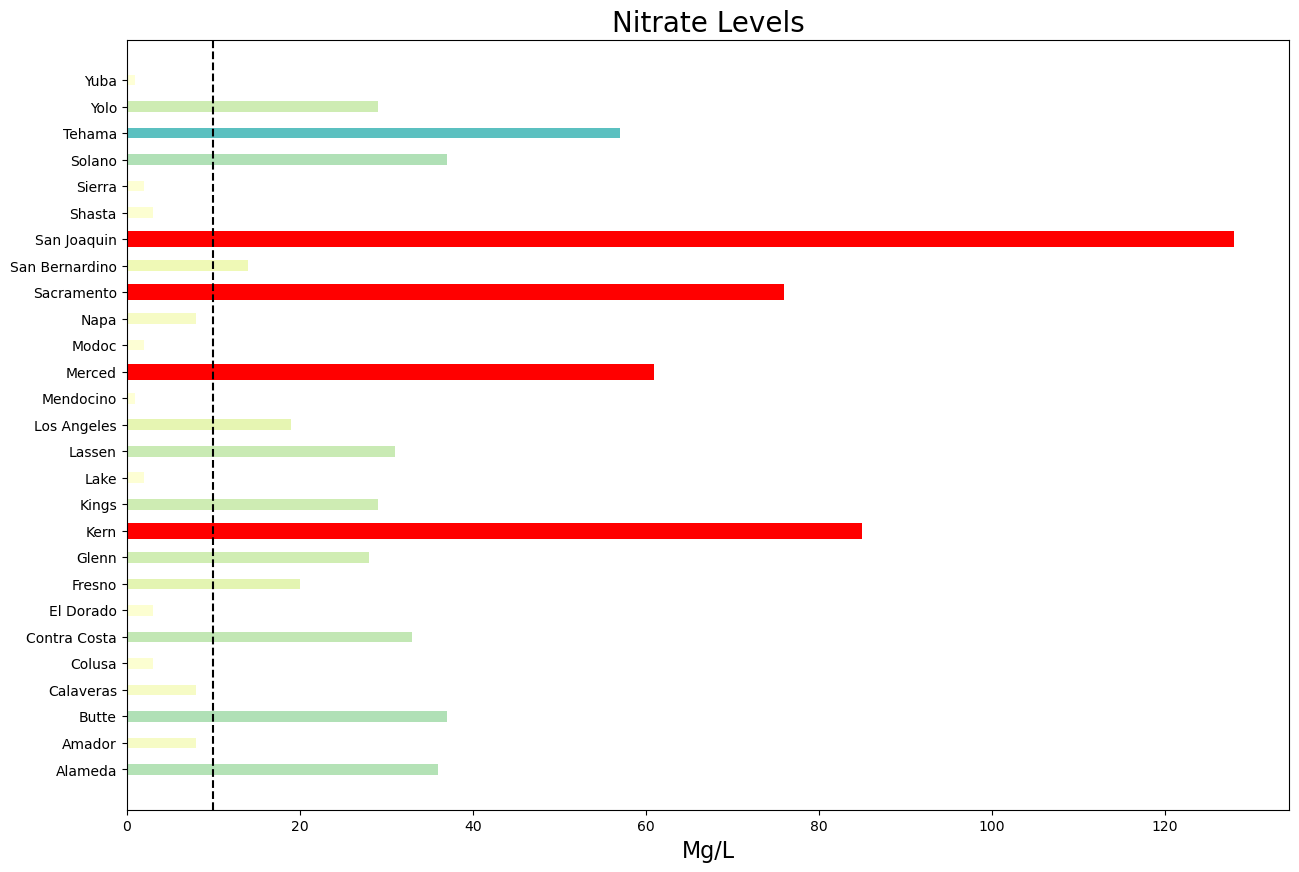

In [96]:

fig = plt.figure(figsize=(15, 10))

county_list = top_offender_df['county_name'].value_counts().index
c_list = []


for county in county_list:
    df = top_offender_df.loc[top_offender_df['county_name']==county]
    result = df["result"].nunique()
    county_dict = {}
    county_dict["county"] = county
    county_dict["result"] = result
    c_list.append(county_dict)
    
    
county_station_df = pd.DataFrame(c_list)
county_station_df = county_station_df.sort_values("county")

n = len(county_station_df)
colormap = plt.cm.YlGnBu
colors = colormap(county_station_df["result"] / county_station_df["result"].max())

plt.barh(county_station_df["county"], county_station_df["result"], color=colors, height=0.4)
plt.xlabel("Mg/L", fontsize=16)
plt.title("Nitrate Levels", fontsize=20)

top_4 = county_station_df.nlargest(4, "result")


for index, row in county_station_df.iterrows():
    if row["county"] in top_4["county"].values:
        plt.barh(row["county"], row["result"], color='red', height=0.6)
    else:
        pass

#plt.xticks(county_station_df["county"], rotation=45, ha='right', fontsize=14, pad=10)

plt.axvline(x=10, color='black', linestyle='--')
plt.show()


# Horizontal Chart 

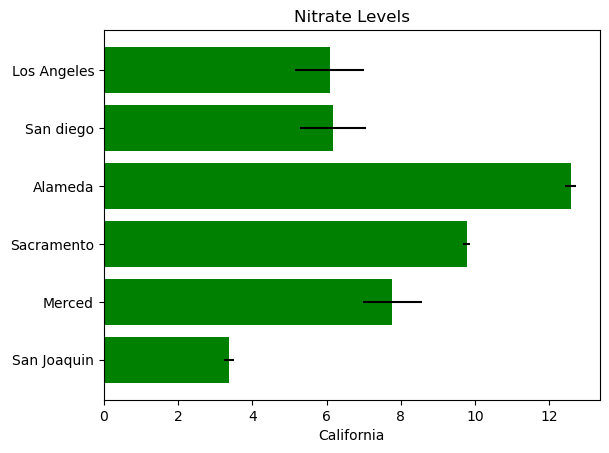

In [45]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Counties of interest
county_name = ('Los Angeles', 'San diego', 'Alameda', 'Sacramento', 'Merced', 'San Joaquin')
y_pos = np.arange(len(county_name))
nitrate_levels = 3 + 10 * np.random.rand(len(county_name))
error = np.random.rand(len(county_name))

ax.barh(y_pos, nitrate_levels, xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(county_name)
ax.invert_yaxis()  

# labels read top-to-bottom
ax.set_xlabel('California')
ax.set_title('Nitrate Levels')

plt.show()

# Pie chart for average of each county over the 10 years


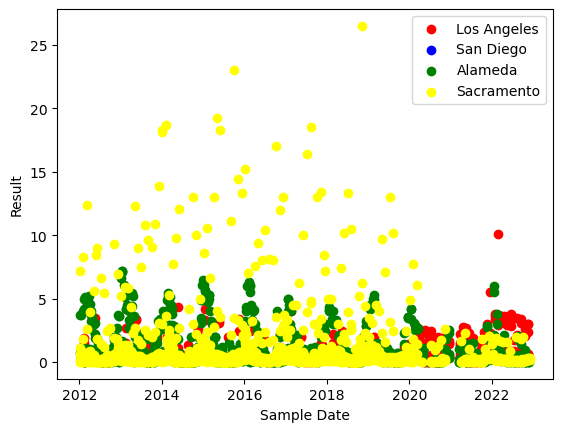

In [42]:
#Scatter plot to see what gragh displays the data best
import matplotlib.pyplot as plt
import pandas as pd

# Counties needed
counties = ['Los Angeles', 'San Diego', 'Alameda', 'Sacramento']
colors = ['red', 'blue', 'green', 'yellow']

fig, ax = plt.subplots()

for county, color in zip(counties, colors):
    county_df = NO3_data_df[NO3_data_df['county_name'] == county]
    ax.scatter(county_df['sample_date'], county_df['result'], c=color, label=county)

ax.legend()
ax.set_xlabel('Sample Date')
ax.set_ylabel('Result')

# Display
plt.show()


# County by County

Text(0, 0.5, 'Nitrate ppb')

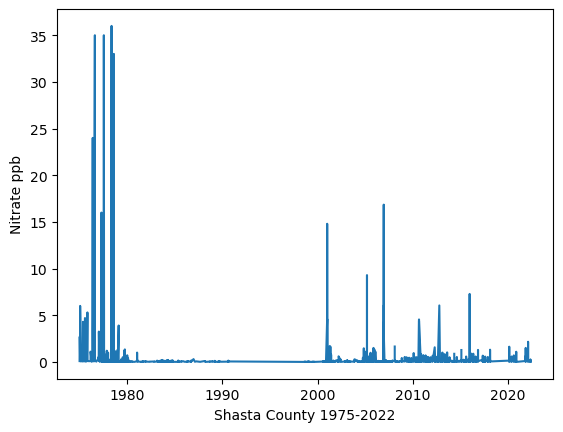

In [80]:
#create a dataframe for Tehama county
Target_County = county_df["county_name"] == "Shasta"
Target_County_df =county_df.loc[Target_County]
Target_County_avg =Target_County_df.groupby("sample_date").mean()["result"]
Target_County_av_df = pd.DataFrame({"Shasta": Target_County_avg})
Tehama_Total_Samples = Target_County_av_df.size

#print(f"There were a total of {Kern_Total_Samples} Nitrate Samples taken for Shasta County between 2012 and in 2022")
plt.plot(Target_County_av_df)
plt.show
#plt.bar(x_axis, Target_County, color='green', alpha=1, align='edge', width=0.6)
#plt.xticks(ticks, type, rotation='vertical')
plt.title = ('Average Nitrate Level 2012-2022')
plt.xlabel('Shasta County 2012-2022')
plt.ylabel('Nitrate ppb')

Text(0, 0.5, 'Nitrate ppb')

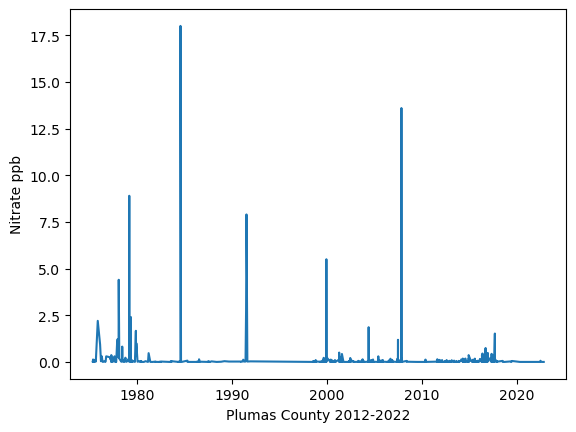

In [81]:
#create a dataframe for Tehama county
Target_County = county_df["county_name"] == "Plumas"
Target_County_df =county_df.loc[Target_County]
Target_County_avg =Target_County_df.groupby("sample_date").mean()["result"]
Target_County_av_df = pd.DataFrame({"Plumas": Target_County_avg})
Tehama_Total_Samples = Target_County_av_df.size

#print(f"There were a total of {LA_Total_Samples} Nitrate Samples taken for Plumas County between 2012 and in 2022")
plt.plot(Target_County_av_df)
plt.show
#plt.bar(x_axis, Target_County, color='green', alpha=1, align='edge', width=0.6)
#plt.xticks(ticks, type, rotation='vertical')
plt.title = ('Average Nitrate Level 2012-2022')
plt.xlabel('Plumas County 2012-2022')
plt.ylabel('Nitrate ppb')